<a href="https://colab.research.google.com/github/KidMarten/CNN-Emotions-Classifier/blob/master/EmotionRecognition_TF2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import pip
import time

!pip install -q tensorflow-gpu==2.0.0-rc0
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, losses, metrics
from tensorflow.keras.utils import plot_model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img


import sklearn
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow_datasets as tfds



print(tf.__version__)

Using TensorFlow backend.


2.0.0-rc0


#### Data import

In [3]:
train_ds = tfds.load(name="celeb_a", split=tfds.Split.TRAIN)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/0.3.0. Subsequent calls will reuse this data.


In [0]:
test_ds = tfds.load(name="celeb_a", split=tfds.Split.TEST)

In [0]:
IMG_SIZE = (218, 178, 3)
BATCH_SIZE = 64
EPOCHS = 10

In [0]:
#train = train_ds.repeat(EPOCHS).shuffle(163000).batch(BATCH_SIZE)#.prefetch(tf.data.experimental.AUTOTUNE)
test = test_ds.repeat(EPOCHS).shuffle(20000).batch(BATCH_SIZE, drop_remainder=True)

#### Model

In [0]:
def model():
  inputs = layers.Input(shape=IMG_SIZE)
  conv1 = layers.Conv2D(filters=64, kernel_size=(5,5), strides=2, activation='relu')(inputs)
  conv1 = layers.BatchNormalization()(conv1)
  conv1 = layers.MaxPooling2D(pool_size=(2,2), strides=1)(conv1)
  conv1 = layers.Dropout(rate=0.3)(conv1)
  
  conv2 = layers.Conv2D(filters=128, kernel_size=(5,5), strides=2, activation='relu')(conv1)
  conv2 = layers.BatchNormalization()(conv2)
  conv2 = layers.MaxPooling2D(pool_size=(2,2), strides=1)(conv2)
  conv2 = layers.Dropout(rate=0.25)(conv2)
  
  conv3 = layers.Conv2D(filters=256, kernel_size=(5,5), strides=2, activation='relu')(conv2)
  conv3 = layers.BatchNormalization()(conv3)
  conv3 = layers.MaxPooling2D(pool_size=(2,2), strides=1)(conv3)
  conv3 = layers.Dropout(rate=0.25)(conv3)

  flatten = layers.Flatten()(conv1)
  dense1 = layers.Dense(512, activation='relu')(flatten)
  dropout = layers.Dropout(rate=0.3)(dense1)
  dense2 = layers.Dense(258, activation='relu')(dropout)
  output = layers.Dense(1, activation='sigmoid', name='output')(dense2)
   
  Model = models.Model(inputs=inputs, outputs=output)
  return Model

In [0]:
model = model()
model.summary()

In [0]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE, pooling='avg')
def IncResNet(base_model):
  
  x = base_model.output
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(512, activation='relu')(x)
  predictions = layers.Dense(1, activation='sigmoid')(x)
  
  model = models.Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  return model

In [0]:
InceptionModel = IncResNet(base_model)
#InceptionModel.summary()

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)

In [0]:
def train_step(model, optimizer, x, y):
  
  with tf.GradientTape() as tape:
    
      prediction = model(x)
      loss = losses.binary_crossentropy(prediction, y)
      
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss, prediction

In [0]:
preds = []
def train(model, dataset, optimizer, log_freq=10):
  
  avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)
  
  for example in dataset:
         
      x = example['image'].numpy().astype(np.float32)/255
      y = example['attributes']['Male'].numpy().astype(np.float32)
      
      loss, prediction = train_step(model, optimizer, x, y)
      avg_loss.update_state(loss)
      
      if tf.equal(optimizer.iterations % log_freq, 0):
        tf.summary.scalar('loss', avg_loss.result(), step=optimizer.iterations)
        print("Loss:", avg_loss.result().numpy())
        avg_loss.reset_states()
        
        print("True label:", y[0])
        print("Pred:", prediction[0].numpy())
        plt.imshow(x[0])
        plt.show()
        preds.append(prediction)

In [0]:
train_summary_writer = tf.summary.create_file_writer('/tmp/summaries/train')

Loss: 5.8071237
True label: 1.0
Pred: [0.]


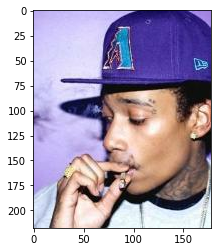

Loss: 5.94163
True label: 0.0
Pred: [0.]


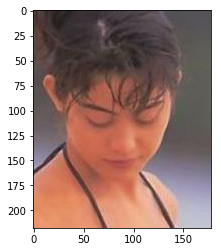

Loss: 5.893714
True label: 0.0
Pred: [0.]


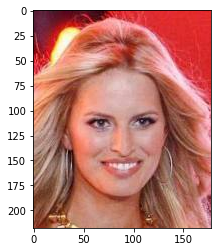

Loss: 6.516627
True label: 1.0
Pred: [0.]


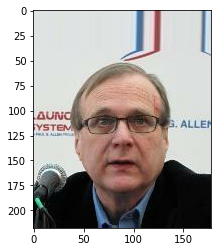

Loss: 6.2770452
True label: 1.0
Pred: [0.]


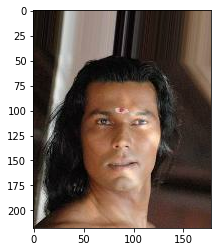

Loss: 5.702049
True label: 0.0
Pred: [0.]


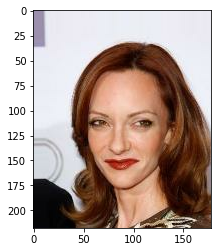

Loss: 6.133296
True label: 0.0
Pred: [0.]


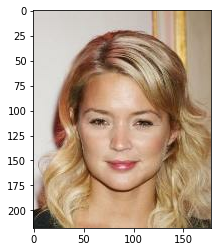

Loss: 6.4447527
True label: 1.0
Pred: [0.]


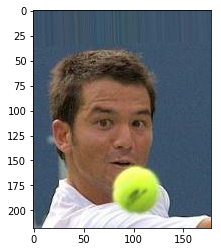

Loss: 5.4864244
True label: 0.0
Pred: [0.]


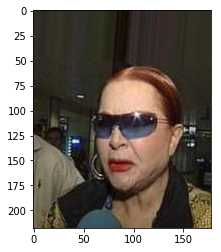

Loss: 6.0853796
True label: 1.0
Pred: [0.]


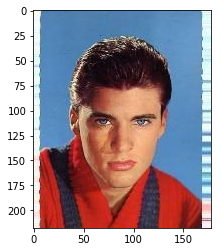

Loss: 5.8697557
True label: 0.0
Pred: [0.]


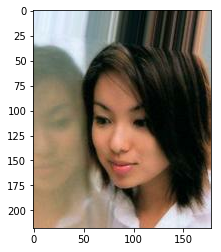

Loss: 6.229129
True label: 0.0
Pred: [0.]


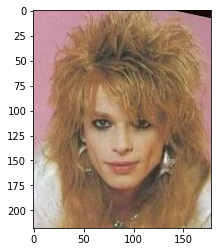

Loss: 6.277045
True label: 0.0
Pred: [0.]


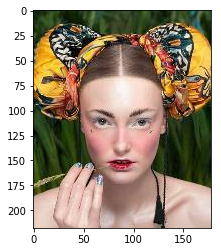

Loss: 5.9895463
True label: 0.0
Pred: [0.]


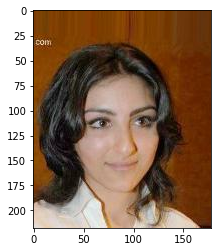

Loss: 5.6062155
True label: 1.0
Pred: [0.]


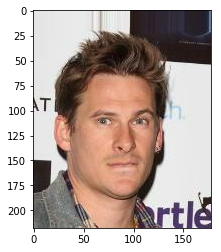

Loss: 5.15101
True label: 0.0
Pred: [0.]


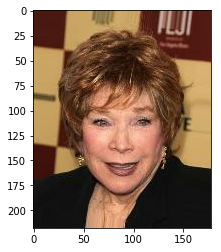

Loss: 5.654132
True label: 0.0
Pred: [0.]


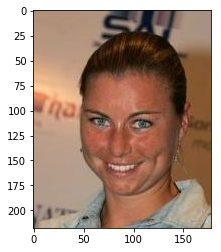

Loss: 6.061422
True label: 1.0
Pred: [0.]


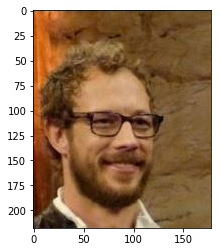

Loss: 6.2770452
True label: 1.0
Pred: [0.]


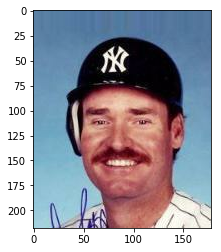

Loss: 6.109338
True label: 0.0
Pred: [0.]


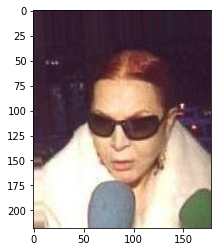

Loss: 5.5822573
True label: 1.0
Pred: [0.]


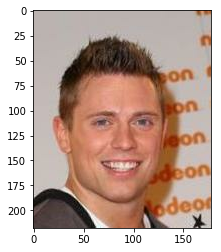

Loss: 5.558299
True label: 0.0
Pred: [0.]


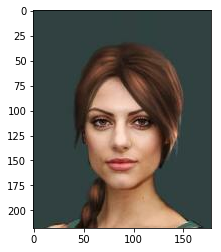

Loss: 5.5822573
True label: 1.0
Pred: [0.]


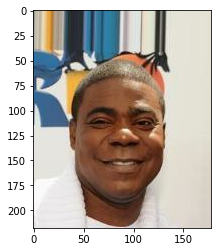

Loss: 6.277045
True label: 1.0
Pred: [0.]


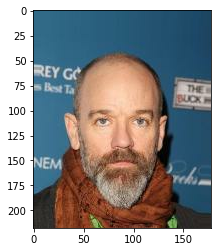

Loss: 6.229128
True label: 1.0
Pred: [0.]


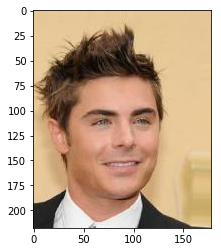

Loss: 6.2530856
True label: 0.0
Pred: [0.]


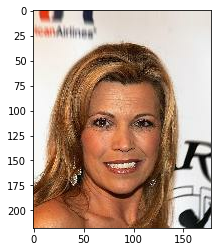

Loss: 6.2291284
True label: 0.0
Pred: [0.]


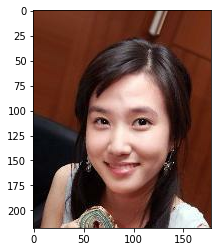

Loss: 6.3968363
True label: 0.0
Pred: [0.]


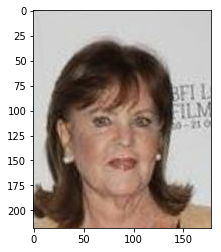

Loss: 6.1332955
True label: 1.0
Pred: [0.]


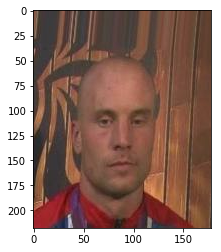

Loss: 6.0614204
True label: 1.0
Pred: [0.]


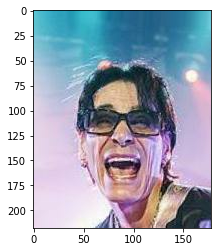

Loss: 5.702049
True label: 0.0
Pred: [0.]


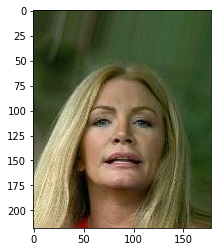

Loss: 5.8457975
True label: 0.0
Pred: [0.]


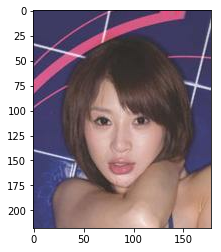

Loss: 6.0374627
True label: 1.0
Pred: [0.]


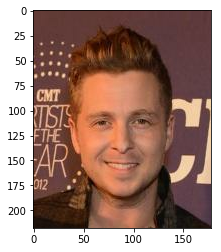

Loss: 5.510383
True label: 1.0
Pred: [0.]


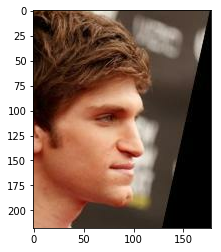

Loss: 5.9416304
True label: 1.0
Pred: [0.]


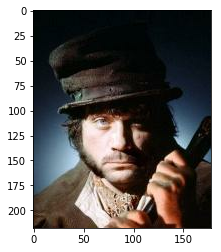

Loss: 6.229129
True label: 1.0
Pred: [0.]


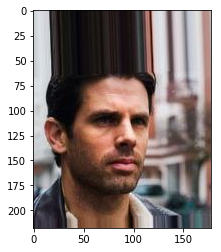

Loss: 5.9655886
True label: 0.0
Pred: [0.]


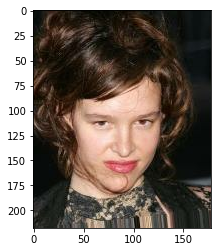

Loss: 5.8697557
True label: 0.0
Pred: [0.]


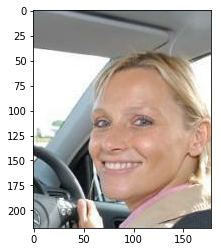

Loss: 5.7260065
True label: 0.0
Pred: [0.]


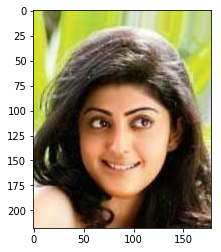

Loss: 5.67809
True label: 0.0
Pred: [0.]


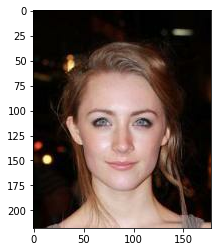

Loss: 6.157254
True label: 0.0
Pred: [0.]


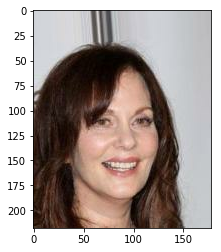

Loss: 6.3728776
True label: 1.0
Pred: [0.]


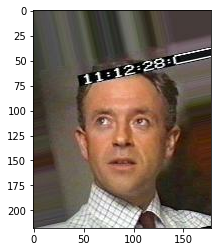

Loss: 5.797881
True label: 0.0
Pred: [0.]


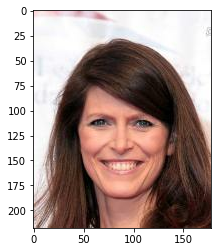

Loss: 5.797881
True label: 0.0
Pred: [0.]


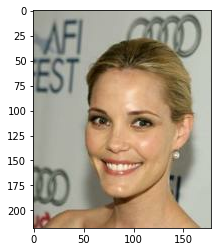

Loss: 5.67809
True label: 0.0
Pred: [0.]


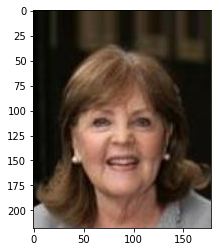

Loss: 5.8218393
True label: 1.0
Pred: [0.]


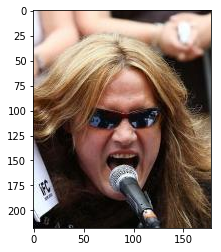

Loss: 6.2051697
True label: 1.0
Pred: [0.]


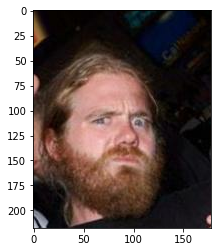

Loss: 5.989547
True label: 0.0
Pred: [0.]


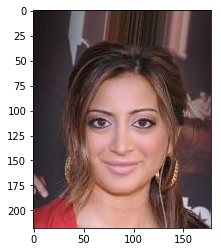

Loss: 5.630174
True label: 1.0
Pred: [0.]


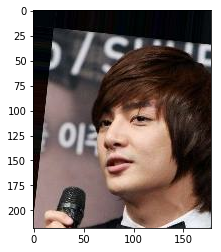

Loss: 5.869756
True label: 0.0
Pred: [0.]


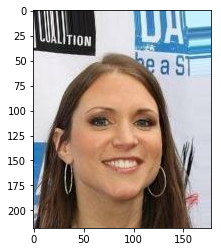

Loss: 6.013505
True label: 1.0
Pred: [0.]


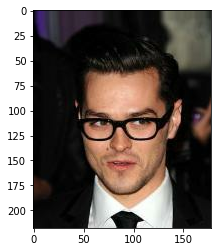

Loss: 6.1812124
True label: 1.0
Pred: [0.]


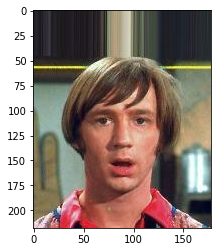

Loss: 6.109338
True label: 1.0
Pred: [0.]


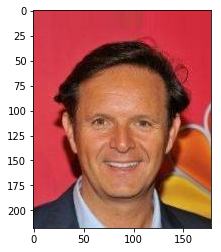

Loss: 5.7499647
True label: 0.0
Pred: [0.]


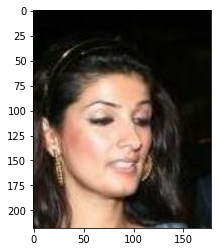

Loss: 5.8457975
True label: 0.0
Pred: [0.]


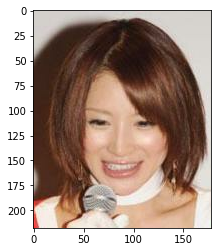

Loss: 5.4864244
True label: 0.0
Pred: [0.]


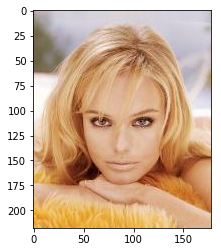

Loss: 5.917671
True label: 1.0
Pred: [0.]


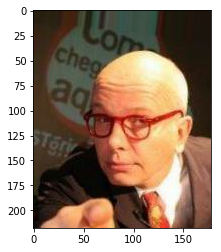

Loss: 5.7260065
True label: 0.0
Pred: [0.]


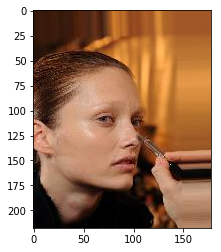

Loss: 5.534341
True label: 0.0
Pred: [0.]


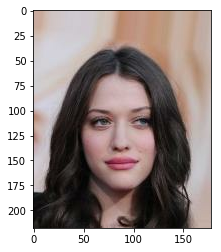

Loss: 6.5405846
True label: 0.0
Pred: [0.]


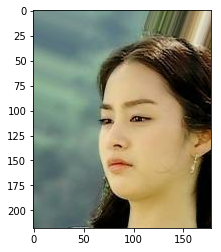

Loss: 6.6124597
True label: 1.0
Pred: [0.]


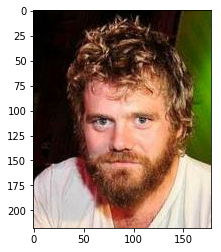

Loss: 5.606216
True label: 0.0
Pred: [0.]


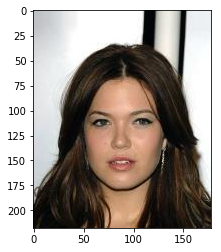

Loss: 5.9416304
True label: 1.0
Pred: [0.]


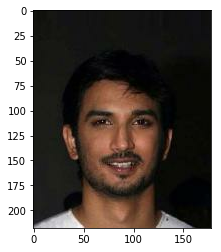

Loss: 5.3187175
True label: 0.0
Pred: [0.]


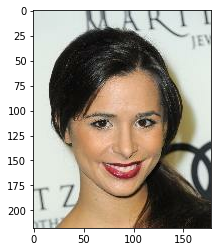

Loss: 5.8457975
True label: 0.0
Pred: [0.]


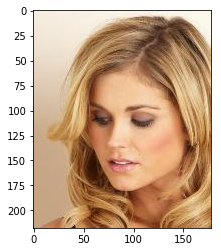

Loss: 6.253087
True label: 1.0
Pred: [0.]


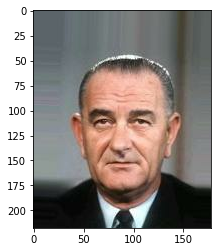

Loss: 5.654132
True label: 0.0
Pred: [0.]


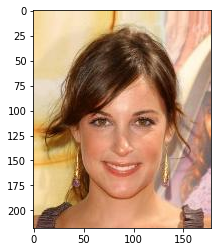

Loss: 5.7499647
True label: 0.0
Pred: [0.]


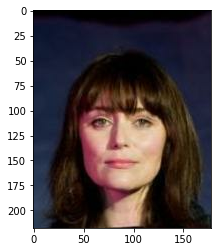

KeyboardInterrupt: ignored

In [52]:
with train_summary_writer.as_default():
  train(InceptionModel, test, optimizer)

In [0]:
preds

1.0
0.0
1.0


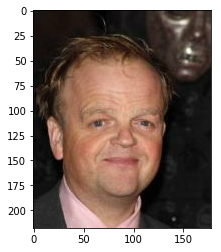

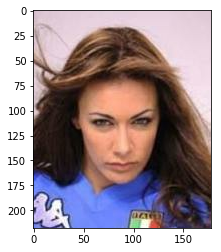

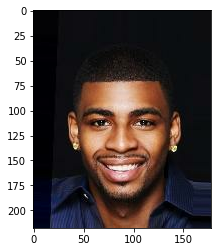

In [19]:
for example in test_ds.take(3):
  plt.cla()
  print(example['attributes']['Male'].numpy().astype(np.float32))
  #print(InceptionModel.predict(np.expand_dims(example['image'], 0).astype(np.float32)))
  plt.imshow(example['image'])
  plt.show()

#### Results

In [0]:
class ClassifierResults:
  def __init__(self, model, x_test, y_test, metrics=[]):
    self.model = model
    self.x_test = x_test
    self.y_test = y_test
    self.metrics = metrics
    self.predictions = self.model.predict(self.x_test)
    
  def display_preds(self, img_array, labels):
    for i in range(img_array.shape[0]):
        print(labels[i])
        plt.imshow(img_array[i])
        plt.show()
  
  def correct_predictions(self, display=False):
    y_test_classes = np.argmax(self.y_test, axis=1)
    y_pred_classes = np.argmax(self.predictions, axis=1)
    mask = (y_test_classes - y_pred_classes == 0)
    correct_preds = self.x_test[mask]
    correct_labels = self.predictions[mask]
    if display:
      self.display_preds(correct_preds, correct_labels)
    return correct_preds
    
  def wrong_predictions(self, display=True):
    y_test_classes = np.argmax(self.y_test, axis=1)
    y_pred_classes = np.argmax(self.predictions, axis=1)
    mask = (y_test_classes - y_pred_classes != 0)
    wrong_preds = self.x_test[mask]
    wrong_labels = self.predictions[mask]
    print('Number of misclassified pictures: ', wrong_preds.shape[0])
    if display:
      self.display_preds(wrong_preds, wrong_labels)
    return wrong_preds
    
  def scores(self):
    for metric in self.metrics:
      score = metric(np.argmax(self.y_test, axis=1), np.argmax(self.predictions, axis=1))
      print(f'{str(metric)}: ', score)
  
  def confusion_matrix(self, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    matrix = confusion_matrix(np.argmax(self.y_test, axis=1), np.argmax(self.predictions, axis=1))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(self.predictions.shape[1])
    plt.xticks(tick_marks, range(self.predictions.shape[1]), rotation=45)
    plt.yticks(tick_marks, range(self.predictions.shape[1]))
    if normalize:
        matrix = np.round(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], 2)
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')